In [1]:
import numpy
import bokeh.plotting as bplot
bplot.output_notebook()
%matplotlib nbagg
from matplotlib import pyplot
from tqdm import tqdm_notebook, tnrange

Loading BokehJS ...

In [2]:
from soapy import WFS, confParse
import aotools

In [3]:
SOAPY_CONF = "conf/wfs/shpixelscale.yaml"

In [18]:
# load Soapy config
config = confParse.loadSoapyConfig(SOAPY_CONF)
mask = aotools.circle(config.sim.pupilSize/2., config.sim.simSize)

<IPython.core.display.Javascript object>


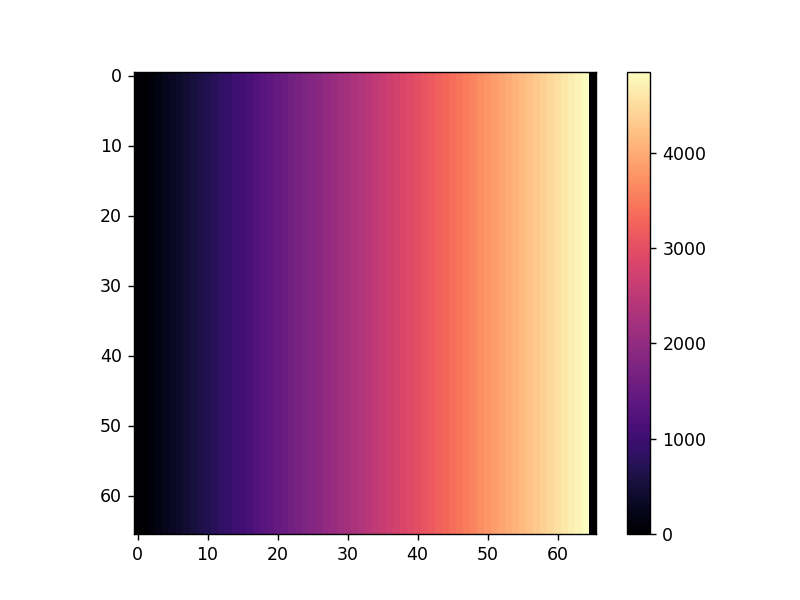

Tilt Amplitude: 4848.14 nm


In [5]:
# One arcec in tilt Amp across scope
tilt_rad = 1./3600 * numpy.pi/180 # angle in radians
tilt_amp = tilt_rad*config.tel.telDiam # amplitude in meters
tilt_amp *= 1e9 # Amplitude in nm

# make a 1-arcsecond tilt
coords = numpy.linspace(0, tilt_amp, config.sim.pupilSize)
scrn_pad = int((config.sim.scrnSize - config.sim.pupilSize)/2.)
coords = numpy.pad(coords, pad_width=(scrn_pad, scrn_pad), mode=("constant"))
tilt = numpy.meshgrid(coords, coords)[0].reshape(1, config.sim.scrnSize, config.sim.scrnSize)

pyplot.figure()
pyplot.imshow(tilt[0])
pyplot.colorbar()
print("Tilt Amplitude: {:.2f} nm".format(tilt_amp))

In [6]:
# Pixel scale to set WFS to
PXL_SCALE = 0.5 #asec/pxl

In [7]:
# Measure current pixel scale
config.wfss[0].subapFOV = config.wfss[0].pxlsPerSubap*PXL_SCALE

maxTilt = config.wfss[0].subapFOV/4. # arcsecs
tilt_amps = numpy.linspace(0, maxTilt, 50) 

wfs = WFS.ShackHartmannFast(config, 0, mask)
print('WFS FOV: {:.2f}"'.format(config.wfss[0].subapFOV))

measuredTilts = numpy.zeros((tilt_amps.shape[0]))
for i in tnrange(len(tilt_amps)):
    A = tilt_amps[i]
    slopes = wfs.frame(tilt * A)
    measuredTilts[i] = -1*slopes[:wfs.n_measurements/2.].mean()
    
    # Check tilt is what I think it is
    dAmp = (((tilt*A)).max() - (tilt*A).min())*1e-9
    angle = (dAmp/config.tel.telDiam) * (180./numpy.pi) * 3600
#     print('Test tilt of {:.2f}"'.format(angle))

WFS FOV: 5.00"


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
A = numpy.vstack([tilt_amps, numpy.ones(len(tilt_amps))]).T
pxlScale, bias = numpy.linalg.lstsq(A, measuredTilts)[0]
print("Measured Pixel Scale: {} pxls/arcsec".format(1./pxlScale))

Measured Pixel Scale: 0.5343085233156609 pxls/arcsec


In [9]:
tilt_amps

array([ 0.        ,  0.0255102 ,  0.05102041,  0.07653061,  0.10204082,
        0.12755102,  0.15306122,  0.17857143,  0.20408163,  0.22959184,
        0.25510204,  0.28061224,  0.30612245,  0.33163265,  0.35714286,
        0.38265306,  0.40816327,  0.43367347,  0.45918367,  0.48469388,
        0.51020408,  0.53571429,  0.56122449,  0.58673469,  0.6122449 ,
        0.6377551 ,  0.66326531,  0.68877551,  0.71428571,  0.73979592,
        0.76530612,  0.79081633,  0.81632653,  0.84183673,  0.86734694,
        0.89285714,  0.91836735,  0.94387755,  0.96938776,  0.99489796,
        1.02040816,  1.04591837,  1.07142857,  1.09693878,  1.12244898,
        1.14795918,  1.17346939,  1.19897959,  1.2244898 ,  1.25      ])

<IPython.core.display.Javascript object>


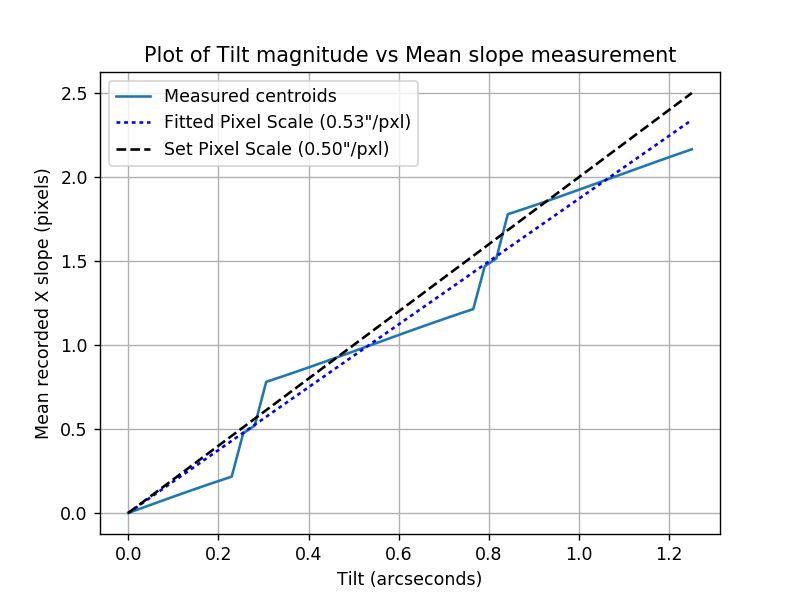

In [10]:
fig = pyplot.figure()
pyplot.plot(tilt_amps, measuredTilts, label="Measured centroids")
pyplot.plot(tilt_amps, pxlScale*tilt_amps, color="blue", label='Fitted Pixel Scale ({:.2f}"/pxl)'.format(1./pxlScale), linestyle=":")
pyplot.plot(tilt_amps, tilt_amps / PXL_SCALE, color="black", linestyle="--", label='Set Pixel Scale ({:.2f}"/pxl)'.format(PXL_SCALE))

pyplot.grid()
pyplot.title("Plot of Tilt magnitude vs Mean slope measurement")
pyplot.xlabel("Tilt (arcseconds)")
pyplot.ylabel("Mean recorded X slope (pixels)")

pyplot.legend(loc=0)

In [23]:
def getMeasurePixelScale(config, samples=50):

    max_tilt = config.wfss[0].subapFOV/4. # arcsecs
    tilt_amps = numpy.linspace(0., max_tilt, samples) 
    
    mask = aotools.circle(config.sim.pupilSize/2., config.sim.simSize)
    wfs = WFS.ShackHartmannFast(config, 0, mask)
    print('WFS FOV: {:.2f}"'.format(config.wfss[0].subapFOV))

    measured_tilts = numpy.zeros((tilt_amps.shape[0]))
    for i in range(len(tilt_amps)):
        A = tilt_amps[i]
        slopes = wfs.frame(tilt * A)
        measured_tilts[i] = -1*slopes[:wfs.n_measurements/2.].mean()
    
    A = numpy.vstack([tilt_amps, numpy.ones(len(tilt_amps))]).T
    pxl_scale, bias = numpy.linalg.lstsq(A, measured_tilts)[0]
    
    return 1./pxl_scale

In [24]:
set_pixel_scales = numpy.linspace(0.2, 1., 50)
measured_pixel_scales = numpy.zeros_like(set_pixel_scales)
for ip in tnrange(len(set_pixel_scales)):
    p = set_pixel_scales[ip]
    config.wfss[0].subapFOV = config.wfss[0].pxlsPerSubap * p
    
    print("Pixel Scale: {}, Subap FOV: {}".format(p, config.wfss[0].subapFOV))
    measured_pixel_scales[ip] = getMeasurePixelScale(config, samples=50)


Pixel Scale: 0.2, Subap FOV: 2.0
WFS FOV: 2.00"


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Pixel Scale: 0.2163265306122449, Subap FOV: 2.163265306122449
WFS FOV: 2.16"
Pixel Scale: 0.2326530612244898, Subap FOV: 2.3265306122448983
WFS FOV: 2.33"
Pixel Scale: 0.2489795918367347, Subap FOV: 2.489795918367347
WFS FOV: 2.49"
Pixel Scale: 0.2653061224489796, Subap FOV: 2.653061224489796
WFS FOV: 2.65"
Pixel Scale: 0.28163265306122454, Subap FOV: 2.8163265306122454
WFS FOV: 2.82"
Pixel Scale: 0.2979591836734694, Subap FOV: 2.979591836734694
WFS FOV: 2.98"
Pixel Scale: 0.3142857142857143, Subap FOV: 3.142857142857143
WFS FOV: 3.14"
Pixel Scale: 0.3306122448979592, Subap FOV: 3.306122448979592
WFS FOV: 3.31"
Pixel Scale: 0.34693877551020413, Subap FOV: 3.4693877551020416
WFS FOV: 3.47"
Pixel Scale: 0.363265306122449, Subap FOV: 3.63265306122449
WFS FOV: 3.63"
Pixel Scale: 0.3795918367346939, Subap FOV: 3.795918367346939
WFS FOV: 3.80"
Pixel Scale: 0.3959183673469388, Subap FOV: 3.959183673469388
WFS FOV: 3.96"
Pixel Scale: 0.41224489795918373, Subap FOV: 4.122448979591837
WFS FOV: 4

<IPython.core.display.Javascript object>


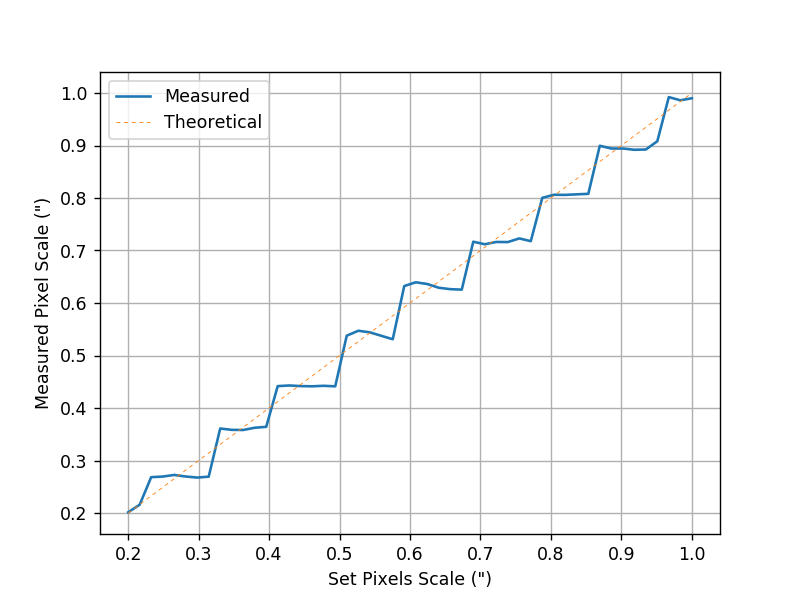

In [25]:
fig = pyplot.figure()
pyplot.plot(set_pixel_scales, measured_pixel_scales, label='Measured')
pyplot.plot(set_pixel_scales, set_pixel_scales, linewidth=0.5, linestyle=":", label="Theoretical")

pyplot.legend()
pyplot.xlabel('Set Pixels Scale (")')
pyplot.ylabel('Measured Pixel Scale (")')
pyplot.grid()


In [14]:
1./measured_pixel_scales[0]

4.9497962321962348

In [15]:
(1.22 * 550e-9/(1./8)) * (180/numpy.pi) * 3600

1.1072294799344133

AttributeError: 'ShackHartmannFast' object has no attribute 'subapFOVSpacing'